In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 

In [2]:
# TF detector
def TF_detector(df_rolling):
    '''
    parameters: dataframe
    <시작 조건>
    시작 조건 0. TF 중 = False
    시작 조건 1. time > 이전 TF 종료 시간
    시작 조건 2. HDD >= {HDD_threshold=500} (time - )
    시작 조건 3. FB > 0, time - {possible_time_variance=1}
    시작 조건 4. HDD >= {HDD_threshold=500} 시간 이후, first FB=False 상태로 HDD < {HDD_lull_cut=50} 생기면 이전 HDD time 제외

    <종료 조건>
    종료 조건 0. TF 진행 중 = True
    종료 조건 1. FB = 0 이 {no_FB_duration=10}초 이상
    종료 조건 2. time = ts_map_end_time

    *stagger
    *길어지는 한타
    FB 0 되고 10s동안 추가 킬이 없어야 한타 종료로 인정

    return:     TF_timestamps: dataframe of [['match_id', 'map_num', 'TF_start_time_stamps', 'TF_end_time_stamps']]
    '''
    global is_TF_ongoing
    is_TF_ongoing = False
    global FB_happened
    FB_happened = False
    global FB_silence
    FB_silence = False

    TF_start_time_stamps = []
    TF_end_time_stamps = []

    HDD_threshold = 500
    HDD_lull_cut = 500
    FB_threshold = 0
    possible_time_variance = 2
    no_FB_duration = 10

    # start condition
    def TF_start(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence
        
        def condition0(): # TF 중 = False
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = False
            else:
                cond0 = True
            return cond0

        def condition1(idx): # time > 이전 TF 종료 시간
            if (idx < df_rolling.index[-1]) == True:
                cond1 = True
            else:
                cond1 = False
            return cond1

        def condition2(idx): # HDD >= {HDD_threshold}
            if df_rolling.loc[idx, 'HDD'] > HDD_threshold:
                cond2 = True
            else:
                cond2 = False
            return cond2 
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # HDD가 오르는 추세에 있어야
            if (df_rolling.loc[idx - no_FB_duration : idx, 'HDD'].mean() <= df_rolling.loc[idx : idx + no_FB_duration, 'HDD'].mean()) == True:
                cond4 = True
            else:
                cond4 = False
            return cond4 
        
        def condition5(idx): # HDD 가 {no_FB_duration} 범위에서 최소값일 경우
            if (df_rolling.loc[idx, 'HDD'] <= df_rolling.loc[idx : idx + no_FB_duration, 'HDD'].min()) == True:
                cond5 = True
            else:
                cond5 = False
            return cond5 


        # check if start_condition == True
        start_condition = condition0() & condition1(idx) & ( (condition2(idx) & condition4(idx) & condition5(idx)) | condition3(idx) ) 
        
        if start_condition == True:
            is_TF_ongoing = True # toggle on
            FB_silence = False # toggle off

        return is_TF_ongoing
    
    # end condition
    def TF_end(idx):
        global is_TF_ongoing
        global FB_happened
        global FB_silence

        def condition0(): # TF 진행 중 = True
            global is_TF_ongoing
            if is_TF_ongoing == True:
                cond0 = True
            else:
                cond0 = False 
            return cond0

        def condition1(idx): # FB = 0 이 {no_FB_duration}초 이상 유지될 때
            global FB_silence
            if df_rolling.loc[idx: idx + no_FB_duration, 'FB'].sum() == 0:
                cond1 = True 
                FB_silence = True # toggle on
            else:
                cond1 = False
            return cond1 
        
        def condition2(idx): # time = ts_map_end_time (Map이 종료됐을 때)
            if idx == df_rolling.index[-1]:
                cond2 = True
            else:
                cond2 = False
            return cond2
        
        def condition3(idx): # FB > 0
            global FB_happened
            if df_rolling.loc[idx, 'FB'] > FB_threshold:
                cond3 = True
                FB_happened = True # toggle on
            else:
                cond3 = False
            return cond3
        
        def condition4(idx): # while FB == 0 & HDD <= {HDD_lull_cut}
            if (df_rolling.loc[idx, 'FB'] == 0) & (df_rolling.loc[idx, 'HDD'] <= HDD_lull_cut):
                cond4 = True
            else:
                cond4 = False
            return cond4
        
        def condition5(idx): # 2s 동안 mean(HDD) < HDD_threshold 
            if df_rolling.loc[idx:idx + 2, 'HDD'].mean() < HDD_threshold:
                cond5 = True
            else:
                cond5 = False
            return cond5

        # init FB_happened
        condition3(idx)

        # check if end_condition == True
        end_condition = ( condition0() & ((condition1(idx) & condition5(idx)) & FB_happened) | (FB_happened & condition4(idx)) ) | condition2(idx)

        if end_condition == True:
            is_TF_ongoing = False # toggle off
            FB_happened = False # toggle off

        return is_TF_ongoing

    TF_status = []

    for idx in df_rolling.index:
        if is_TF_ongoing == False:
            TF_status.append(TF_start(idx))
        else:
            TF_status.append(TF_end(idx))

    df_rolling['TF_status'] = TF_status

    return df_rolling # [['RCP', 'HDD', 'FB', 'TF_status']], index=UTC timestamp

In [3]:
# get TF_time_range
def get_true_range(df=None, column='TF_status'):
    '''
    parameters: data: dataframe with timestamp index
                column: target column to arrange
    
    returns:    index tuple
    '''
    range_list = []
    prev_val = False

    for inx, val in df[column].iteritems():
        if prev_val != val:
            if val:
                start = inx
            else:
                range_list.append((start, inx))

        prev_inx = inx
        prev_val = val
    
    TF_time_range = pd.DataFrame(range_list, columns=['TF_start_time', 'TF_end_time'])
    
    return TF_time_range # df[['TF_start_time', 'TF_end_time']]

In [4]:
from TraditionalStat import *
from AdvancedStat import * 

In [5]:
class ScrimLog():
    def __init__(self, csvname=None):
        self.csvname = csvname + '.csv'
        self.match_id = csvname[0:11] # match_id: '(yyyymmdd)_(scrimNum)' (e.g. 20200318_02)
        self.set_directory()
        self.set_df_input()
        self.set_index()
        self.set_WorkshopStat()
        self.set_TraditionalStat()
        self.set_AdvancedStat()
        self.set_df_merge()

    def set_directory(self):
        '''
        naming:     '(yyyy:mm:dd)_(scrimNum)_(enemyTeamName)_(mapName)' e.g. '20210318_02_O2_Oasis'
        match_id:   '(yyyy:mm:dd)_(scrimNum)' e.g. '20210318_02'
        '''
        path = 'G:/공유 드라이브/NYXL Scrim Log/Csv'
        self.filepath = os.path.join(path, self.csvname)

    def set_df_input(self):
        self.df_input = pd.read_csv(self.filepath)

    def set_index(self):
        # df_init
        self.df_init = self.df_input 
        
        # match_id
        self.df_init['MatchId'] = self.match_id

        # team name
        NYE_alt_names = ['NYXL', 'Team 1', '1팀', 'New York Excelsior', 'New York']
        team_one_name = self.df_init['Team'].unique()[0]
        team_two_name = self.df_init['Team'].unique()[1]

        if team_one_name == 'NYE':
            pass
        elif team_one_name in NYE_alt_names:
            self.df_init['Team'] = self.df_init['Team'].replace({team_one_name:'NYE'})
            team_one_name = 'NYE'
        elif team_two_name == 'NYE':
            team_one_name = self.df_init['Team'].unique()[1]
            team_two_name = self.df_init['Team'].unique()[0]
        elif team_two_name in NYE_alt_names:
            self.df_init['Team'] = self.df_init['Team'].replace({team_two_name:'NYE'})
            team_one_name = self.df_init['Team'].unique()[1]
            team_two_name = 'NYE'
        else:
            raise Exception('NYE is not designated as Team 1. Check the Team names')
        
        self.team_one_name = team_one_name
        self.team_two_name = team_two_name

        # idx_col
        self.idx_col = ['MatchId', 'Map', 'Section', 'RoundName', 'Timestamp', 'Point', 'Team', 'Player', 'Hero']
    
    def set_WorkshopStat(self):
        df_WorkshopStat = self.df_init.groupby(self.idx_col).sum()

        self.df_WorkshopStat = df_WorkshopStat
    
    def set_TraditionalStat(self):

        # TimePlayed        
        df_TraditionalStat = TimePlayed(self.df_WorkshopStat).get_df_result()
        # AllDamageDealt
        df_TraditionalStat = AllDamageDealt(df_TraditionalStat).get_df_result()
        # Cooldown1Percent
        df_TraditionalStat = Cooldown1Percent(df_TraditionalStat).get_df_result()
        # Cooldown2Percent
        df_TraditionalStat = Cooldown2Percent(df_TraditionalStat).get_df_result()
        # HealthPercent
        # df_TraditionalStat = HealthPercent(df_TraditionalStat).get_df_result() # Health column 추가되면 진행
        # NumAlive
        df_TraditionalStat = NumAlive(df_TraditionalStat).get_df_result()

        # stat/s 
        '''
        현재 스크림 워크샵이 영웅별로 스탯을 누적해주는 것이 아니라 플레이어 별로 스탯을 누적해주기 때문에 선수가 도중에 영웅을 바꿀 경우 diff() 함수에서 문제가 발생 --> `hero_col` 따로 빼서 diff() 구하고 나중에 merge로 해결
        '''
        def diff_stat(df_input=None):
            diff_stat_list = [] # define stat names to diff()
            df_init = df_input.reset_index()
            # grouping = [x for x in self.idx_col if x != 'Hero']
            grouping = [x for x in self.idx_col if x not in ['Hero', 'Point']]
            hero_col = df_init.set_index(grouping)['Hero']
            df_group = df_init.groupby(by=grouping).sum()
            dx = df_group.groupby([x for x in grouping if x != 'Timestamp']).diff().fillna(0)
            df_merge = pd.merge(df_group, dx, how='outer', left_index=True, right_index=True, suffixes=('', '/s'))
            df_merge = pd.merge(df_merge, hero_col, how='outer', left_index=True, right_index=True) # add hero_col

            return df_merge
        
        # calculate dx table and merge
        df_TraditionalStat = diff_stat(df_input=df_TraditionalStat)

        # indexing
        df_TraditionalStat = df_TraditionalStat.groupby(by=self.idx_col).sum()

        self.df_TraditionalStat = df_TraditionalStat

    def set_TF_Timeline(self):
        pass

    def set_AdvancedStat(self):
        # RCP
        df_AdvancedStat = RCPv1(self.df_TraditionalStat).get_df_result()
        # FB_value
        df_AdvancedStat = FBValue(df_AdvancedStat).get_df_result()
        # Death_risk
        df_AdvancedStat = DeathRisk(df_AdvancedStat).get_df_result()

        # indexing
        df_AdvancedStat = df_AdvancedStat.groupby(by=self.idx_col).sum()

        self.df_AdvancedStat = df_AdvancedStat
    
    def set_df_merge(self):
        # team names
        team_one_name = self.team_one_name
        team_two_name = self.team_two_name 

        '''
        현재 스크림 워크샵이 영웅별로 스탯을 누적해주는 것이 아니라 플레이어 별로 스탯을 누적해주기 때문에 선수가 도중에 영웅을 바꿀 경우 diff() 함수에서 문제가 발생 --> `hero_col` 따로 빼서 diff() 구하고 나중에 merge로 해결
        '''
        grouping = ['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player', 'Hero']
        # grouping = ['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player']
        hero_col = self.df_init.set_index(['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player'])['Hero']
        df_group = self.df_init.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player']).sum()
        dx = df_group.groupby([x for x in ['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player'] if x != 'Timestamp']).diff().fillna(0)
        df_merge = pd.merge(df_group, dx, how='outer', left_index=True, right_index=True, suffixes=('', '/s'))
        df_merge = pd.merge(df_merge, hero_col, how='outer', left_index=True, right_index=True) # add

        df_merge = df_merge.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player', 'Hero']).sum()

        # add Alives
        section_list = df_merge.reset_index('Section')['Section'].unique()
        player_list = df_merge.reset_index('Player')['Player'].unique()

        # set rolling df by moving window Multiindex=['Map', 'Section', 'Team', 'Timestamp']
        rolling = pd.DataFrame()

        for section in section_list:
            for player in player_list:
                df_tmp = df_merge.xs((section, player), level=['Section', 'Player'], drop_level=False)
                rolling_tmp = df_tmp.groupby(by=['Map', 'Section','Team', 'Timestamp']).sum()
                rolling_tmp = rolling_tmp.rolling(window=10).sum().fillna(rolling_tmp) # default window=10 sec
                rolling = pd.concat([rolling, rolling_tmp])

        alives = 6 - rolling.groupby(by=['Map', 'Section', 'Timestamp', 'Team']).sum()[['Deaths/s']]
        alives.rename(columns = {'Deaths/s':'Alives'}, inplace=True)


        X = alives.xs(team_one_name, level='Team', drop_level=False)
        Y = alives.xs(team_two_name, level='Team', drop_level=False)

        # add RCP
        def Alives(X, Y):
            df_merge = pd.merge(X, Y, how='outer', on=[x for x in X.index.names if x != 'Team'], suffixes=(f'_{team_one_name}', f'_{team_two_name}'))
            df_merge['RCP'] = (df_merge[f'Alives_{team_one_name}']**2 - df_merge[f'Alives_{team_two_name}']**2) / (df_merge[[f'Alives_{team_one_name}', f'Alives_{team_two_name}']].max(axis=1)) # Af = (A0^2 - B0^2)/A0
            df_merge['RCP'].fillna(0) # fill nan=0 in case X == Y == 0

            return df_merge    

        Alives = Alives(X, Y)
        df_merge = pd.merge(df_merge, Alives, how='outer', left_index=True, right_index=True)

        ## FB_value and Death risk
        team_one = df_merge.xs(team_one_name, level='Team', drop_level=False)
        team_two = df_merge.xs(team_two_name, level='Team', drop_level=False)

        # RCP
        def RCP(X, Y):
            RCP = (X**2 - Y**2).div(X)
            RCP = RCP.fillna(-Y) # fill nan = -Y in case X == 0
            return RCP

        # add FB value
        def FB_value(X, Y, FB):
            FB_value = RCP(X, Y - FB) - RCP(X, Y)
            return FB_value 
        
        def Death_risk(X, Y, Death):
            Death_risk = RCP(X, Y) - RCP(X - Death, Y)
            return Death_risk
        
        # FB value
        team_one_FB_value = FB_value(team_one[f'Alives_{team_one_name}'],  team_one[f'Alives_{team_two_name}'], team_one['FinalBlows/s'])
        team_two_FB_value = FB_value(team_two[f'Alives_{team_two_name}'],  team_two[f'Alives_{team_one_name}'], team_two['FinalBlows/s'])

        FB_value = pd.concat([team_one_FB_value, team_two_FB_value]).groupby(by=grouping).max()
        FB_value.rename('FB_value', inplace=True)

        # Death risk
        team_one_Death_risk = Death_risk(team_one[f'Alives_{team_one_name}'],  team_one[f'Alives_{team_two_name}'], team_one['Deaths/s'])
        team_two_Death_risk = Death_risk(team_two[f'Alives_{team_two_name}'],  team_two[f'Alives_{team_one_name}'], team_two['Deaths/s'])

        Death_risk = pd.concat([team_one_Death_risk, team_two_Death_risk]).groupby(by=grouping).max()
        Death_risk.rename('Death_risk', inplace=True)

        df_merge = pd.merge(df_merge, FB_value, how='outer', left_index=True, right_index=True)
        df_merge = pd.merge(df_merge, Death_risk, how='outer', left_index=True, right_index=True)

        # get TF_info
        def TF_info(df_merge):
            df_merge = df_merge.reset_index()
            section_list = df_merge['Section'].unique()
            df_merge = df_merge.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp', 'Team', 'Player', 'Hero']).sum()

            TF_rolling = pd.DataFrame()
            for section in section_list:
                df_tmp = df_merge.xs(section, level='Section', drop_level=False)
                TF_rolling_tmp = df_tmp.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp']).sum()
                TF_rolling_tmp = TF_rolling_tmp.rolling(window=10, center=True).sum().fillna(TF_rolling_tmp) # default window=10 sec
                TF_rolling = pd.concat([TF_rolling, TF_rolling_tmp])

            TF_rolling = TF_rolling.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp']).sum()[['HeroDamageDealt/s', 'FinalBlows/s']]
            TF_rolling.rename(columns={'HeroDamageDealt/s':'HDD', 'FinalBlows/s':'FB'}, inplace=True)

            RCP = df_merge.groupby(by=['MatchId', 'Map', 'Section', 'Timestamp']).max()[['RCP']]

            TF_rolling = pd.merge(TF_rolling, RCP, how='outer', left_index=True, right_index=True)

            TF_info = pd.DataFrame()
            for section in section_list:
                TF_rolling_tmp = TF_rolling.xs(section, level='Section', drop_level=False)
                TF_rolling_tmp = TF_rolling_tmp.reset_index()
                TF_rolling_tmp = TF_rolling_tmp.set_index('Timestamp')
                df_TF = TF_detector(TF_rolling_tmp) # TF_detector
                TF_time_range = get_true_range(df_TF)

                # define TF winner and RCP
                TF_winner_list = []
                TF_order_list = []
                TF_duration_list = []
                TF_RCP_list = []
                TF_order = 0
                
                for idx in TF_time_range.index:
                    TF_order += 1
                    TF_order_list.append(TF_order)
                    TF_duration_list.append((TF_time_range.loc[idx, 'TF_end_time'] - TF_time_range.loc[idx, 'TF_start_time'])) # TF duration in s
                    TF_RCP_sum = TF_rolling_tmp.loc[TF_time_range.loc[idx, 'TF_start_time']:TF_time_range.loc[idx, 'TF_end_time'], 'RCP'].sum()
                    TF_RCP_list.append(TF_RCP_sum) # RCP
                    if TF_RCP_sum > 0:
                        TF_winner_list.append(team_one_name)
                    elif TF_RCP_sum == 0:
                        TF_winner_list.append('draw')
                    else:
                        TF_winner_list.append(team_two_name)
                TF_time_range['TF_order'] = TF_order_list
                TF_time_range['TF_winner'] = TF_winner_list
                TF_time_range['TF_duration'] = TF_duration_list
                TF_time_range['TF_RCP_sum'] = TF_RCP_list

                TF_time_range['MatchId'] = self.match_id
                TF_time_range['Map'] = self.df_init['Map'].unique()[0]
                TF_time_range['Section'] = section

                TF_info = pd.concat([TF_info, TF_time_range])
            
            return TF_info

        self.TF_info = TF_info(df_merge)

        # add TF_info
        tmp_merge = pd.DataFrame()
        for section in section_list:
            tmp = df_merge.xs(section, level='Section', drop_level=False)
            tmp = tmp.reset_index().set_index('Timestamp')
            TF_info_tmp = self.TF_info[self.TF_info['Section'] == section]
            for idx in TF_info_tmp.index:
                start, end = TF_info_tmp.loc[idx, 'TF_start_time'], TF_info_tmp.loc[idx, 'TF_end_time']
                tmp.loc[start:end, 'TF_order'] = TF_info_tmp.loc[idx, 'TF_order']
                tmp.loc[start:end, 'TF_winner'] = TF_info_tmp.loc[idx, 'TF_winner']
                tmp.loc[start:end, 'TF_duration'] = TF_info_tmp.loc[idx, 'TF_duration']
                tmp.loc[start:end, 'TF_RCP_sum'] = TF_info_tmp.loc[idx, 'TF_RCP_sum']
            
            tmp_merge = pd.concat([tmp_merge, tmp])
        
        df_merge = tmp_merge

        # reset index and grouping
        def indexing(df):
            df = df.reset_index()
            df = df.groupby(by=grouping).max()
            return df 
        
        self.df_merge = indexing(df_merge)
    
    def get_df_merge(self):
        return self.df_merge
    
    def get_TF_info(self):
        return self.TF_info

    def export_to_csv(self):
        self.df_merge.to_csv(f'results/{scrim.csvname}')


In [6]:
filename = '20210325_01_HZS_Dorado'
scrim = ScrimLog(filename)
df_WorkshopStat = scrim.df_WorkshopStat
df_TraditionalStat = scrim.df_TraditionalStat
df_AdvancedStat = scrim.df_AdvancedStat
display(df_AdvancedStat[['FBValue', 'DeathRisk']])

d:\owl-data\Project\project 5_scrim stat log\TraditionalStat.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_level_col['new_col'] = stat_level_col['HeroDamageDealt'] + stat_level_col['BarrierDamageDealt']
C:\Users\jyc13\anaconda3\envs\owl-data\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
d:\owl-data\Project\project 5_scrim stat log\TraditionalStat.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

FBValue  \
MatchId     Map    Section RoundName Timestamp Point Team Player  Hero                     
20210325_01 Dorado 0       Defense   0.00      0.00  NYE  BiaNcA  Zarya              0.0   
                                                          Flora   Ashe               0.0   
                                                          Friday  Mercy              0.0   
                                                          JJonak  Zenyatta           0.0   
                                                          Yakpung Wrecking Ball      0.0   
...                                                                                  ...   
                           Offense   778.99    99.98 NYE  Flora   Ashe               0.0   
                                                          Friday  Mercy              0.0   
                                                          JJonak  Zenyatta           0.0   
                                                          Yakpung Wrecking Ball      0.0   
                                                          ivy     Echo               0.0   

                                                                                 DeathRisk  
MatchId     Map    Section RoundName Timestamp Point Team Player  Hero                      
20210325_01 Dorado 0       Defense   0.00      0.00  NYE  BiaNcA  Zarya                0.0  
                                                          Flora   Ashe                 0.0  
                                                          Friday  Mercy                0.0  
                                                          JJonak  Zenyatta             0.0  
                                                          Yakpung Wrecking Ball        0.0  
...                                                                                    ...  
                           Offense   778.99    99.98 NYE  Flora   Ashe                 0.0  
                                                          Friday  Mercy                0.0  
                                                          JJonak  Zenyatta             0.0  
                                                          Yakpung Wrecking Ball        0.0  
                                                          ivy     Echo                 0.0  

[8496 rows x 2 columns]

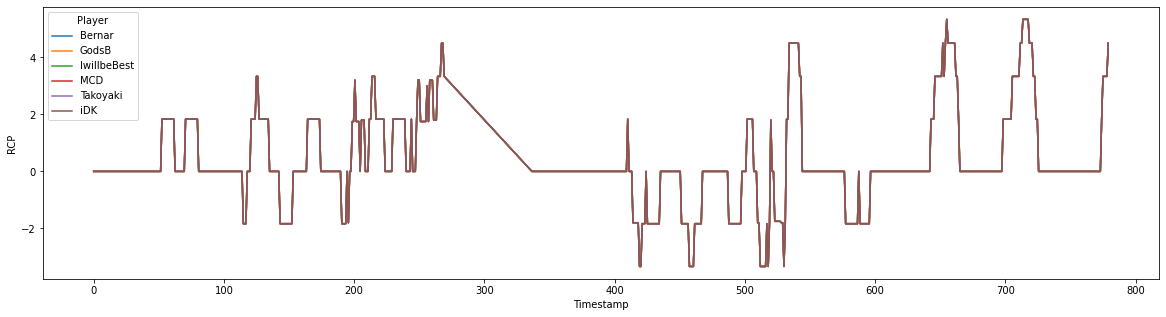

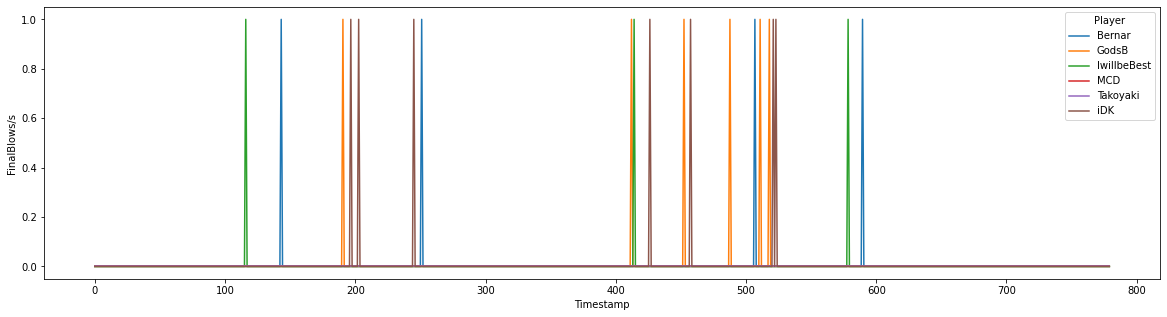

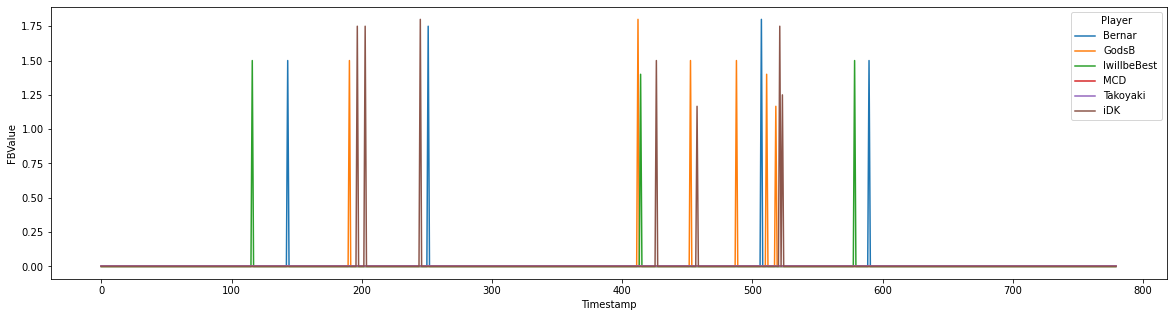

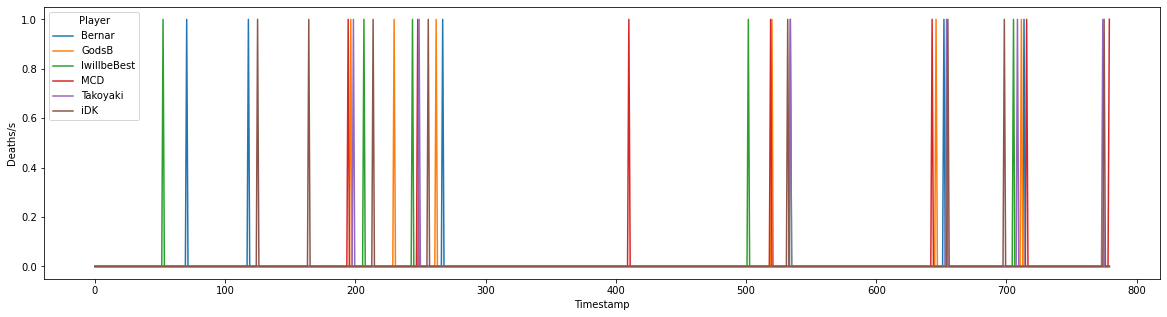

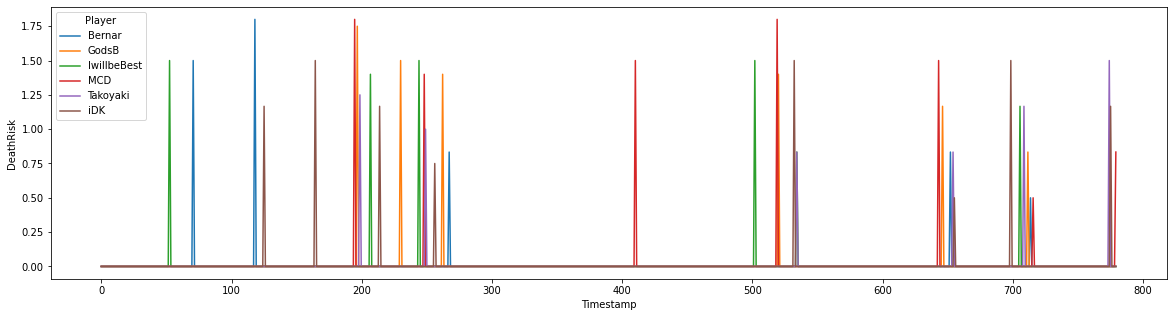

In [8]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='RCP', data=df_AdvancedStat.xs((0, 'HZS'), level=['Section', 'Team']), hue='Player')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='FinalBlows/s', data=df_TraditionalStat.xs((0, 'HZS'), level=['Section', 'Team']), hue='Player')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='FBValue', data=df_AdvancedStat.xs((0, 'HZS'), level=['Section', 'Team']), hue='Player')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='Deaths/s', data=df_TraditionalStat.xs((0, 'HZS'), level=['Section', 'Team']), hue='Player')
plt.show()
plt.figure(figsize=(20,5))
sns.lineplot(x='Timestamp', y='DeathRisk', data=df_AdvancedStat.xs((0, 'HZS'), level=['Section', 'Team']), hue='Player')
plt.show()

In [ ]:
filename = '20210318_02_O2B_Oasis'
scrim = ScrimLog(filename)
df_merge = scrim.get_df_merge()
display(df_merge)

# save
# scrim.export_to_csv()

In [ ]:
class PETH():
    def __init__(self, df_init=None, event_name=None, period=5):
        self.df_init = df_init.reset_index()
        self.period = period 
        self.event_name = event_name

    def find_events(self, of=[]):
        threshold = 1
        event_onsets = self.df_init[self.df_init[self.event_name] >= threshold]

        team_list = event_onsets['Team'].unique()
        player_list = event_onsets['Player'].unique()
        hero_list = event_onsets['Hero'].unique()

        if any(list(set(of) & set(team_list))):
            event_onsets = event_onsets[event_onsets['Team'] == list(set(of) & set(team_list))[0]]
        if any(list(set(of) & set(player_list))):
            event_onsets = event_onsets[event_onsets['Player'] == list(set(of) & set(player_list))[0]]
        if any(list(set(of) & set(hero_list))):
            event_onsets = event_onsets[event_onsets['Hero'] == list(set(of) & set(hero_list))[0]]

        return event_onsets 

    def set_PETH(self, of=[]):
        of = of
        event_onsets = self.find_events(of)
        section_list = event_onsets['Section'].unique()
        
        event_aligned = pd.DataFrame()
        for section in section_list:
            num_event = 0
            events_in_section = event_onsets[event_onsets['Section'] == section]
            df_in_section = self.df_init[self.df_init['Section'] == section].set_index('Timestamp')
            for event_onset in events_in_section['Timestamp']:
                event_recorder = df_in_section.loc[event_onset-self.period:event_onset+self.period]
                reindex_timestamp = np.linspace(-self.period, self.period, 2*self.period + 1) # reindex example: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
                event_recorder = event_recorder.reset_index()
                for i in reindex_timestamp:
                    event_recorder['Timestamp'] = event_recorder['Timestamp'].replace({event_onset+i:i}) # set timestamp from -5 to 5
                event_recorder['num_event'] = num_event 
                num_event += 1
                event_aligned = pd.concat([event_aligned, event_recorder])
        
        event_aligned = event_aligned.groupby(by=['Match_id', 'Map', 'Section', 'num_event', 'Timestamp', 'Team', 'Player', 'Hero']).sum()
        
        return event_aligned 

    def get_PETH(self, of=[]):
        result = self.set_PETH(of=of)

        return result


In [ ]:
df_peth_FB = PETH(df_init=df_merge, event_name='Final Blows/s', period=10)
df_peth_FB_of_NYE = df_peth_FB.get_PETH(of=['O2 Blast']).groupby(by=['Match_id', 'Map', 'Section', 'num_event', 'Timestamp', 'Team', 'Player', 'Hero']).sum()
df_peth_FB_of_NYE_NYE = df_peth_FB_of_NYE.xs((1, 'O2 Blast'), level=['Section', 'Team'])

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='Cooldown 1', data=df_peth_FB_of_NYE_NYE, hue='Hero')
plt.show()

plt.figure(figsize=(20, 10))
sns.lineplot(x='Timestamp', y='Cooldown 2', data=df_peth_FB_of_NYE_NYE, hue='Hero')
plt.show()

In [ ]:
'''
PETH 개념을 거꾸로 가져가서 몇 가지 event가 동시에 or interval 이내에 일어났을 때를 기준으로 (t=0) 'deaths/s', 'final blows/s' 등의 event 확률 histogram 보여주는 기능 추가
'''